In [2]:
# Import raw data from Excel
import pandas as pd
filepath = 'C:/Users/PXY/Desktop/Orange_week.xlsx';
sheetname = 'main'
df = pd.read_excel ( filepath, sheet_name = sheetname );
print (df)

     Year    Week  Cases  Rainfalls  No.of Raindays  Max. temperature  \
0    2010   week1    NaN        NaN             NaN               NaN   
1    2010   week2    NaN        NaN             NaN               NaN   
2    2010   week3    NaN        NaN             NaN               NaN   
3    2010   week4    NaN      286.0            22.0         32.883871   
4    2010   week5    NaN        NaN             NaN               NaN   
5    2010   week6    NaN        NaN             NaN               NaN   
6    2010   week7    NaN        NaN             NaN               NaN   
7    2010   week8   36.0      241.8            11.0         34.385714   
8    2010   week9   65.0        NaN             NaN               NaN   
9    2010  week10   46.0        NaN             NaN               NaN   
10   2010  week11   31.0        NaN             NaN               NaN   
11   2010  week12   27.0      191.8            14.0         34.338710   
12   2010  week13   40.0        NaN             NaN

                  Rainfalls  Max. temperature  Min. temperature  Mean temp  \
Rainfalls          1.000000         -0.339572         -0.276648  -0.415492   
Max. temperature  -0.339572          1.000000          0.702841   0.928815   
Min. temperature  -0.276648          0.702841          1.000000   0.864220   
Mean temp         -0.415492          0.928815          0.864220   1.000000   
Cases              0.171039         -0.261803         -0.159618  -0.217271   

                     Cases  
Rainfalls         0.171039  
Max. temperature -0.261803  
Min. temperature -0.159618  
Mean temp        -0.217271  
Cases             1.000000  


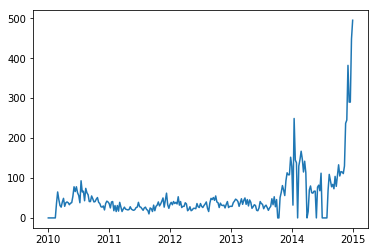

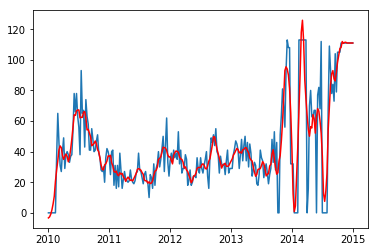

In [11]:
# Data preprocessing
# Set NaN to 0.0 for Cases & Fatality
df['Cases'].fillna( 0, inplace = True )
df['Fatality'].fillna(0, inplace = True )

# Set others to first found values
df['Rainfalls'].ffill( inplace = True );
df['Max. temperature'].ffill( inplace = True );
df['Min. temperature'].ffill( inplace = True );
df['Mean temp'].ffill( inplace = True );

# Ffill doesn't fill in the first three NaN, thus need to do another bfill
df['Rainfalls'].bfill( inplace = True );
df['Max. temperature'].bfill( inplace = True );
df['Min. temperature'].bfill( inplace = True );
df['Mean temp'].bfill( inplace = True );

# Add new column
import datetime 
date = []
for index,row in df.iterrows():
    row['Date'] = datetime.datetime.strptime( str( row['Year'])+ row['Week'] + "-1", "%Yweek%W-%w")
    date.append( row['Date'])

df['Date'] = date

# Verify if all the anomalies are gone and new column added succesfully
df.dtypes

# Create a new data frame
data = pd.DataFrame()
data['Date'] = df['Date']
data['Rainfalls'] = df['Rainfalls'];
data['Max. temperature'] = df['Max. temperature']
data['Min. temperature'] = df['Min. temperature']
data['Mean temp'] = df['Mean temp']
data['Cases'] = df['Cases']

# Since there is no case reported since 2015, drop 2015 data from time series prediction
data.drop(data.tail(52).index,inplace=True) #drop bottom 52 which is data from 2015 

# Show the data in chart
import matplotlib
import matplotlib.pyplot as plt
plt.figure()
dates = matplotlib.dates.date2num(df['Date'])
plt.plot_date(data['Date'], data['Cases'], linestyle = 'solid', marker = 'None')
#plt.plot_date(data['Date'], data['Max. temperature'], linestyle = 'solid', marker = 'None', color = 'red')
#plt.plot_date(data['Date'], data['Min. temperature'], linestyle = 'solid', marker = 'None', color = 'green')
#plt.plot_date(data['Date'], data['Rainfalls'], linestyle = 'solid', marker = 'None', color = 'black')
#plt.plot_date(data['Date'], data['Mean temp'], linestyle = 'solid', marker = 'None', color = 'orange' )

print( data.corr() )

# Filter anomalies by using mean+std dev or mean - std dev
std_value = data['Cases'].std()
mean_value = data['Cases'].mean()
max_boundary = mean_value + std_value
min_boundary = max( mean_value - std_value, 0 )
index = ( data['Cases'] > max_boundary ) | ( data['Cases'] < min_boundary )

import numpy as np
data.loc[index,'Cases'] = np.nan
data['Cases'].bfill( inplace = True );
data['Cases'].ffill( inplace = True );

plt.figure()
plt.plot_date(data['Date'], data['Cases'], linestyle = 'solid', marker = 'None' )

from scipy.signal import savgol_filter
filtered_case = savgol_filter(data['Cases'], 11,2)
plt.plot_date(data['Date'],filtered_case,color ='red', linestyle = 'solid', marker= 'None')
plt.show()

In [4]:
# Normalizing data
# This step is really useful on improving model performance
import sklearn
from sklearn.preprocessing import MinMaxScaler
cols_to_norm = [ 'Max. temperature','Cases']
sc = MinMaxScaler();
scaled_data = data.copy()
scaled_data[cols_to_norm] = sc.fit_transform(data[cols_to_norm])
 
# Split into train and test sets",
train_size = int(len(data) * 0.8)
test_size = len(data) - train_size
train, test = scaled_data[:train_size], scaled_data.tail(test_size)

# Get the subset of the data for training
training_set = train.iloc[:, [2,5]].values
# Define the timestep
timestep = 5

# Create input for training
import numpy as np
X_train = []
y_train =[]
for i in range(timestep, len(training_set)):
    X_train.append(training_set[i-timestep:i,[0,1]]);
    y_train.append(training_set[i,1])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 2))   

In [12]:
# Build and train the model
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

regressor = tf.keras.Sequential()

regressor.add(LSTM(units = timestep, return_sequences = True, input_shape = (X_train.shape[1], 2)))
regressor.add(Dropout(0.2) )

regressor.add(LSTM(units = timestep, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = timestep, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = timestep))
regressor.add(Dropout(0.2))

regressor.add(Dense(units = 1))

regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
203/203 [==============================] - 4s 21ms/sample - loss: 0.1240
Epoch 2/100
203/203 [==============================] - 0s 2ms/sample - loss: 0.1100
Epoch 3/100
203/203 [==============================] - 0s 2ms/sample - loss: 0.0973
Epoch 4/100
203/203 [==============================] - 0s 2ms/sample - loss: 0.0830
Epoch 5/100
203/203 [==============================] - 0s 2ms/sample - loss: 0.0731
Epoch 6/100
203/203 [==============================] - 0s 2ms/sample - loss: 0.0581
Epoch 7/100
203/203 [==============================] - 0s 2ms/sample - loss: 0.0482
Epoch 8/100
203/203 [==============================] - 0s 2ms/sample - loss: 0.0424
Epoch 9/100
203/203 [==============================] - 0s 2ms/sample - loss: 0.0321
Epoch 10/100
203/203 [==============================] - 0s 2ms/sample - loss: 0.0311
Epoch 11/100
203/203 [==============================] - 0s 2ms/sample - loss: 0.0305
Epoch 12/100
203/203 [==============================] - 0s 2ms/sample - l

In [16]:
# Create test data for prediction
test_set = training_set[-timestep:]
test_set = np.concatenate(( (test.iloc[:, [2,5]].values),test_set ) )
X_test = []

for i in range(timestep, len(test) + timestep ):
    X_test.append(test_set[i-timestep:i, [0,1]])
   
X_test = np.array(X_test)

# Make prediction
predicted_cases = regressor.predict(X_test)

# Transform prediction result
result = np.zeros(shape=(len(predicted_cases),2))
result[:,1] = predicted_cases[:,0]
predict = sc.inverse_transform(result)[:,1]
print(predict)

[29.08144891 27.08675215 30.80033749 40.82061499 59.16215062 80.55849957
 81.47288728 80.85672629 80.17455912 76.2238735  62.96863294 42.48083216
 29.26176366 39.64216888 54.49936941 56.49848455 50.47967365 48.38841927
 46.61066395 44.34277567 44.33802053 62.59982002 59.27688015 48.20089772
 39.21761778 23.92437905 24.1644816  25.93291354 32.01365238 45.84281334
 66.94941199 73.24299383 67.39887369 64.33838248 66.24550319 67.60788429
 72.79948616 71.32960927 76.65325046 76.98504603 77.60524821 78.53259468
 78.36151743 78.17148697 77.85340452 77.21512473 76.36990881 75.75431359
 75.81483722 75.97890973 76.27162695 76.1089015 ]


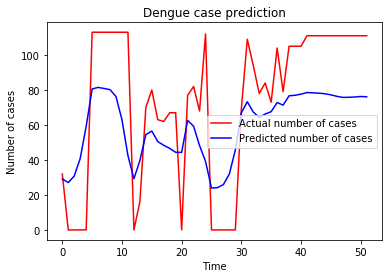

In [17]:
# Get real data
real_cases = data['Cases'].tail(test_size).values

# Visualising the results
plt.plot(data['Date'].tail(test_size),real_cases, color = 'red', label = 'Actual number of cases')
plt.plot(data['Date'].tail(test_size), predict, color = 'blue', label = 'Predicted number of cases')
plt.title('Dengue case prediction')
plt.xlabel('Time')
plt.ylabel('Number of cases')
plt.legend()
plt.show()

# Calculate RMSE
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(real_cases, predict))
print('Test RMSE: %.3f' % rmse)